# Visualizing Itô processes

## Ornstein–Uhlenbeck

Here, we will keep it to the basics, and instead we will just model a mean-reverting Ornstein–Uhlenbeck process given by
\begin{equation*}
dX_t = \theta(\mu-X_t)dt + \sigma_tdW_t,
\end{equation*}
where $\mu$ is a stationary mean, and, for simplicity, we will also consider $\sigma_t$ to not vary with time.

100%|██████████| 5/5 [00:00<00:00, 36.17it/s]


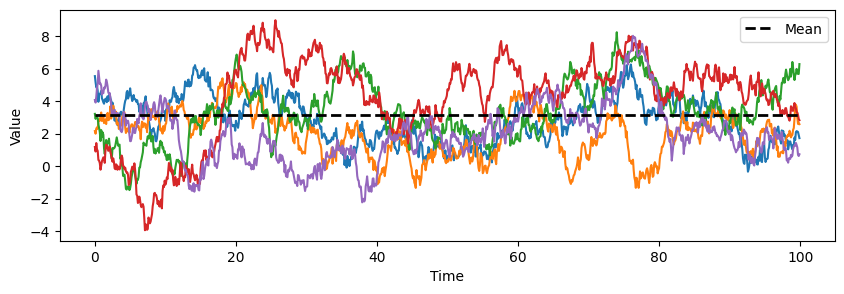

In [1]:
from typing import Union

import numpy as np
from tqdm import tqdm

from quant_learn.utils.funcs import ConstantFunction
from quant_learn.stochastic_processes.ito import ItoProcess as Ito

# Define drift
class OUDrift():
    def __init__(self,
                 mean: Union[float, np.ndarray],
                 scale: Union[float, np.ndarray]) -> None:
        self.mean = mean
        self.scale = scale
    
    def __call__(self, time: float, x: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
        mu = self.mean
        theta = self.scale
        return theta * (mu - x)
    
# Choose parameters
mean = 3.14159
scale = 0.1
drift = OUDrift(mean=mean, scale=scale)
diffusion = ConstantFunction(constant=1.0)
rng_seed = 27182818284

ou_proc = Ito(infinitesimal_time_interval=0.1,
              drift=drift,
              stochastic_stepper=diffusion,
              seed=rng_seed
              )

# Simulate being off from the mean
num_simulations = 5
num_steps = 1000
for _ in tqdm(range(num_simulations)):
    start_val = np.random.uniform(low=0, high=6)
    timestamps, values = ou_proc.simulate(num_steps=num_steps, start_value=start_val)

fig, axes = ou_proc.plot_runs(subplots_args={'figsize': (10, 3)})
axes.plot([timestamps[0], timestamps[-1]], [mean, mean],
          'k--', linewidth=2, label='Mean')
_ = axes.legend()

## Geometric Brownian motion

We can also simulate a geometric Brownian motion, given by
\begin{equation*}
dX_t = \mu X_t dt + \sigma X_t dW_t
\end{equation*}

The solution to this equation has the form
\begin{equation*}
X_t = X_0 \exp\left[\left(\mu -\frac{\sigma^2}{2} \right)t + \sigma W_t\right]
\end{equation*}

100%|██████████| 10000/10000 [00:26<00:00, 376.84it/s]


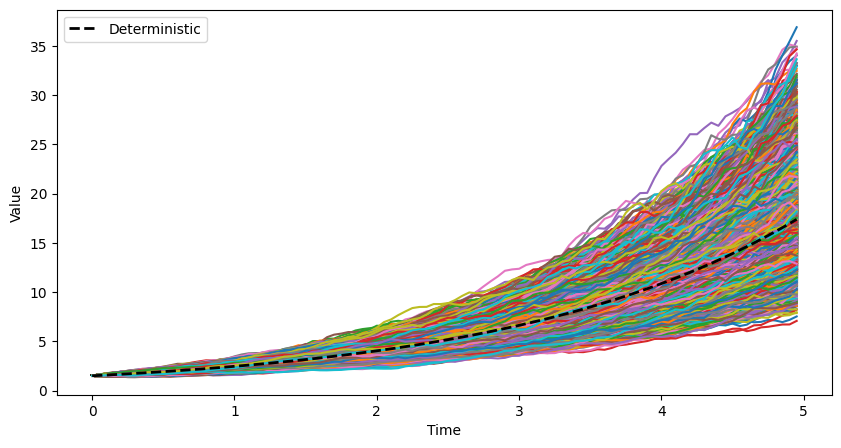

In [2]:
class SimpleScale():
    def __init__(self, scale: Union[float, np.ndarray], power: float = 1.):
        self.scale = scale
        self.power = power

    def __call__(self, time: float, x: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
        return self.scale * (x ** self.power)
    
# Define parameters
mu = 0.5
sigma2 = 0.01  # NOTE: this is not actually the same sigma, as it provides the covariance!
drift = SimpleScale(scale=mu)
diffusion = SimpleScale(scale=sigma2, power=2)  # Again, recall this provides a covariance!
rng_seed = 62831

gbm = Ito(infinitesimal_time_interval=0.05,
          drift=drift,
          stochastic_stepper=diffusion,
          seed=rng_seed)

# Simulate
num_simulations = 10000
num_steps = 100
start_val = 1.5
for _ in tqdm(range(num_simulations)):
    timestamps, values = gbm.simulate(num_steps=num_steps, start_value=start_val)

# Plot
fig, axes = gbm.plot_runs(subplots_args={'figsize': (10, 5)})
# Let's also plot the "deterministic" part of the solution to the stochastic differential equation above
deterministic_sol = start_val * np.exp((mu - (sigma2/2.)) * timestamps)
axes.plot(timestamps, deterministic_sol,
          'k--', linewidth=2, label='Deterministic')
_ = axes.legend(loc='upper left')

At each timestamp, we should expect the ratio between the geometric Brownian motion paths and the deterministic part to be log-normal distributed. I am not going to do a full hypothesis test here, but I will plot these values for ocular inspection.

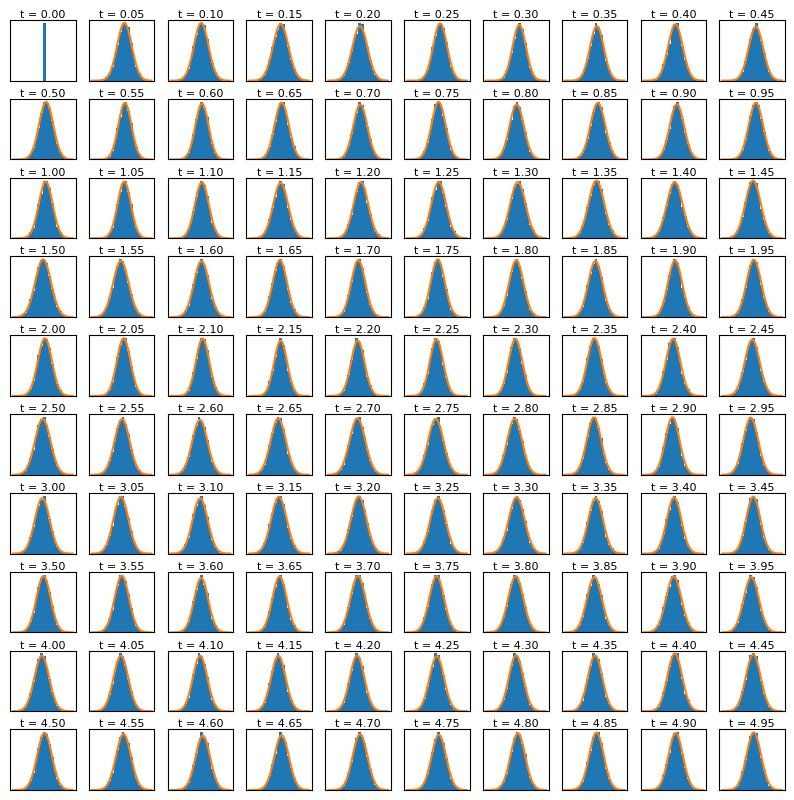

In [3]:
import matplotlib.pyplot as plt

full_vals = np.array([vals for _, vals in gbm.simulation_history])
ratios = np.log(full_vals / deterministic_sol)

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
# fig.tight_layout()
fig.subplots_adjust(hspace=0.3)

for i in range(10):
    for j in range(10):
        index = 10*i + j
        time = timestamps[index]
        var = time * sigma2
        mean = np.mean(ratios[:, index])
        axes[i,j].hist(ratios[:, index], bins=20, density=True)
        # plot a Gaussian PDF
        if time > 0:
            x_lims = axes[i,j].get_xlim()
            x_vals = np.linspace(x_lims[0], x_lims[1], 100)
            pdf = 1./(np.sqrt(2 * np.pi * var)) * np.exp(-(x_vals - mean)**2 / (2 * var))
            axes[i,j].plot(x_vals, pdf)

        # Clean up
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
        axes[i,j].set_title(f't = {time:.2f}', fontsize=8, y=0.9)

Let's also look at some of the statistics of this process.

First, and quite critically, note, that the mean of $X_t$ is not simply the deterministic portion of this equation. Let's see if we can calculate what $E\left[X_t\right]$ should be , as well as $Var\left[X_t\right]$. Start by taking out the clearly constant terms from the expected value:
\begin{equation*}
E\left[X_t\right] = X_0 e^{\mu t} E\left[\exp\left(\sigma W_t - \frac{\sigma^2}{2}t\right)\right]
\end{equation*}

The second expected value looks pretty ugly, but as it turns out, it is a Martingale! To see this, let 
\begin{align*}
S_t &= \sigma W_t \implies dS_t = \sigma dW_t \\
Z(t, S_t) &= \exp\left(S_t - \frac{\sigma^2}{2}t\right)
\end{align*}

We can use Itô's lemma to compute $dZ_t$:
\begin{align*}
\frac{\partial Z}{\partial t} &= -\frac{\sigma^2}{2} Z \\
\frac{\partial Z}{\partial S} &= Z \\
\frac{\partial^2 Z}{\partial S^2} &= Z \\
dZ_t &= \left(\frac{\partial Z}{\partial t} + \frac{\sigma^2}{2}\frac{\partial Z}{\partial S}\right) dt + \frac{\partial Z}{\partial S}dS_t \\
&= \left(-\frac{\sigma^2}{2} Z + \frac{\sigma^2}{2} Z\right) dt + \sigma Z dW_t \\
dZ_t &= \sigma Z_t dW_t
\end{align*}

Therefore, we can see that $Z_t$ is basically a geometric Brownian motion without drift, meaning that the expected value of increments $E[dZ_t]=0$ and $Z_t$ is a martingale. Therefore, $E[Z_t] = E[Z_0] = 1 \implies E[X_t] = X_0 e^{\mu t}$.

From this, the variance becomes easy to compute, as $\left(E[X_t]\right)^2=X_0^2 e^{2\mu t}$ and we only need to calculate $E[X_t^2]$, but we know that
\begin{align*}
X_t^2 &= X_0^2\exp((2\mu-\sigma^2)t + 2\sigma W_t) \\
&= X_0^2 e^{2\mu t} \exp\left[(2\sigma)W_t-\sigma^2 t\right] \\
&= X_0^2 e^{2\mu t} \exp\left[(2\sigma)W_t - 2\sigma^2 t + \sigma^2 t\right] \\
&= X_0^2 e^{(2\mu + \sigma^2) t} \exp\left[(2\sigma)W_t - \frac{(2\sigma)^2}{2} t\right] \implies \\
\implies E[X_t^2] &= X_0^2 e^{(2\mu + \sigma^2) t}
\end{align*}

Note how we used the same $Z_t$ as before, but with a scale of 2 on the $\sigma$ term, which does not affect its martingale-ness nor its expected value. Therefore, we have
\begin{equation*}
Var[X_t] = X_0^2 e^{2\mu t}\left(e^{\sigma^2 t} - 1\right)
\end{equation*}

Mean fit
Slope: 0.9729634256279622
Intercept: 0.061409874456048286
R-squared: 0.9999970140646838
Variance fit
Slope: 0.9005255758482731
Intercept: 0.013069398291463585
R-squared: 0.9999908182342025


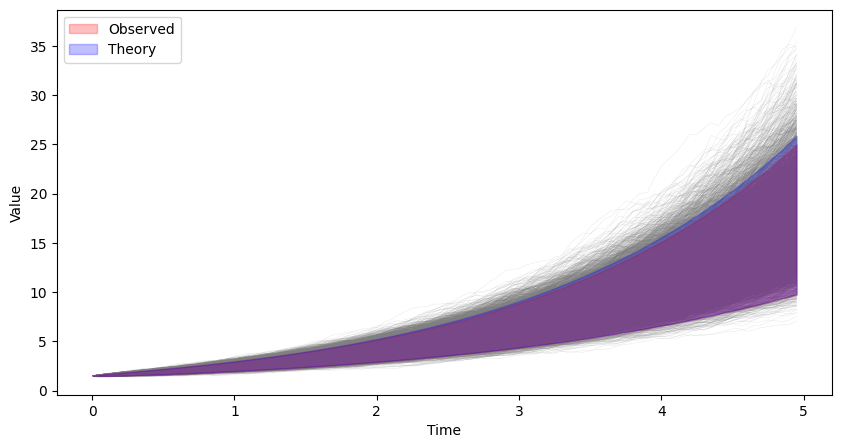

In [4]:
from scipy.stats import linregress

# Calculate what we expected the mean and covariances to be
theoretical_mean = start_val * np.exp(mu * timestamps)
theoretical_var = start_val * start_val * np.exp(2 * mu * timestamps) * (np.exp(sigma2 * timestamps) - 1.)
theoretical_std = np.sqrt(theoretical_var)

# Compute the observed mean and covariance
observed_mean = np.mean(full_vals, axis=0)
observed_cov = np.cov(full_vals.T)
observed_var = observed_cov.diagonal()
observed_std = np.sqrt(observed_var)

# Fit
mean_res = linregress(x=theoretical_mean, y=observed_mean)
var_res = linregress(x=theoretical_var, y=observed_var)

print('Mean fit')
print(f'Slope: {mean_res.slope}')
print(f'Intercept: {mean_res.intercept}')
print(f'R-squared: {mean_res.rvalue}')
print('===================================')
print('Variance fit')
print(f'Slope: {var_res.slope}')
print(f'Intercept: {var_res.intercept}')
print(f'R-squared: {var_res.rvalue}')

# fig, axes = plt.subplots(1, 1, figsize=(10, 5))
fig, axes = gbm.plot_runs(subplots_args={'figsize': (10, 5)},
                          plot_args={'color': 'gray',
                                     'linewidth': 0.2,
                                     'alpha': 0.3,
                                     'zorder': 0})
axes.fill_between(timestamps,
                  observed_mean - 2 * observed_std,
                  observed_mean + 2 * observed_std,
                  color='r', alpha=0.25, label='Observed', zorder=1)
axes.fill_between(timestamps,
                  theoretical_mean - 2 * theoretical_std,
                  theoretical_mean + 2 * theoretical_std,
                  color='b', alpha=0.25, label='Theory', zorder=2)
_ = axes.legend(loc='upper left')